# Building makemore exercise

## Imports

In [1]:
from collections import defaultdict, Counter
import numpy
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn.functional as F

In [2]:
g = torch.Generator().manual_seed(2147483647)

## E01
> Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### Counting

Read in the data

In [3]:
with open('../data/names.txt') as f:
    words = list(map(lambda x: x.strip(), f.readlines()))

In [4]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [5]:
def generate_tripling(words):
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            yield ch1, ch2, ch3

In [6]:
alphabets = '.abcdefghijklmnopqrstuvwxyz'
stoi = {char: alphabets.index(char) for char in alphabets}
itos = dict(map(reversed, stoi.items()))

In [7]:
for ch1, ch2, ch3 in generate_tripling(words[:3]): print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .
. o l
o l i
l i v
i v i
v i a
i a .
. a v
a v a
v a .


In [8]:
sum(1 for ch1, ch2, ch3 in generate_tripling(words))

196113

In [9]:
def generate_tripling_counter(words):
    tripling_counter = Counter()
    for ch1, ch2, ch3 in generate_tripling(words):
        tripling_counter[(ch1, ch2, ch3)] += 1
    return tripling_counter    

In [10]:
tripling_counter = generate_tripling_counter(words)
tripling_counter.most_common(10)

[(('a', 'h', '.'), 1714),
 (('n', 'a', '.'), 1673),
 (('a', 'n', '.'), 1509),
 (('o', 'n', '.'), 1503),
 (('.', 'm', 'a'), 1453),
 (('.', 'j', 'a'), 1255),
 (('.', 'k', 'a'), 1254),
 (('e', 'n', '.'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '.'), 953)]

In [11]:
len(tripling_counter)

6037

In [12]:
def create_matrix():
    N = torch.zeros((27, 27, 27), dtype=torch.int32)
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1
    return N  

In [13]:
N = create_matrix(); N.shape

torch.Size([27, 27, 27])

In [14]:
N[1, 8, 0]

tensor(1714, dtype=torch.int32)

In [15]:
P = (N+1).float()
P = P/P.sum(-1, keepdims=True)

In [16]:
def generate_tripling_prob(words):
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1, ix2, ix3]
        yield ch1, ch2, ch3, prob

In [17]:
for ch1, ch2, ch3, prob in generate_tripling_prob(words[:3]): 
    print(ch1, ch2, ch3, prob)

. e m tensor(0.1855)
e m m tensor(0.1269)
m m a tensor(0.3744)
m a . tensor(0.0669)
. o l tensor(0.2494)
o l i tensor(0.1084)
l i v tensor(0.0219)
i v i tensor(0.2669)
v i a tensor(0.1578)
i a . tensor(0.3657)
. a v tensor(0.0550)
a v a tensor(0.1882)
v a . tensor(0.1405)


In [18]:
def generate_names(count, P):
    g = torch.Generator().manual_seed(2147483647)
    for i in range(count):
        out = []
        ix1, ix2 = 0, 0
        while True:
            p = P[ix1, ix2]
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples = 1, replacement = True, generator=g).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        yield ''.join(out)

In [19]:
for name in generate_names(5, P): print(name)

quia.
yu.
quinslyntien.
nolliahi.
ha.


In [20]:
def log_likelihood(words):
    sum_log = 0
    count = 0
    for ch1, ch2, ch3, prob in generate_tripling_prob(words):
        sum_log += torch.log(prob)
        count += 1
    return sum_log/count

In [21]:
len(P)

27

In [22]:
log_likelihood(words)

tensor(-2.0927)

negative log likelihood

In [23]:
- log_likelihood(words)

tensor(2.0927)

### NN

In [24]:
def generate_training_set(words):
    xs1 = []
    xs2 = []
    ys = []
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs1.append(ix1)
        xs2.append(ix2)
        ys.append(ix3)
    xs1 = torch.tensor(xs1)
    xs2 = torch.tensor(xs2)
    xs = torch.vstack((xs1, xs2)).permute(1, 0)
    ys = torch.tensor(ys)
    return xs, ys 

#### Sample dataset

In [25]:
xs, ys = generate_training_set(words[:1])

In [26]:
xs.shape, ys.shape

(torch.Size([4, 2]), torch.Size([4]))

In [27]:
xenc = F.one_hot(xs, num_classes=27)

In [28]:
xenc.shape

torch.Size([4, 2, 27])

In [29]:
xenc

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])

In [30]:
xenc_flattened = xenc.view(4, -1).float()

In [31]:
W = torch.randn((27*2, 27), generator=g)
W

tensor([[ 1.5674, -0.2373, -0.0274,  ..., -0.0707,  2.4968,  2.4448],
        [-0.6701, -1.2199,  0.3031,  ...,  0.8032,  0.5411, -1.1646],
        [ 0.1476, -1.0006,  0.3801,  ..., -0.6279,  0.0770, -1.1641],
        ...,
        [ 0.5283, -0.9056, -0.0124,  ..., -0.9310, -0.0919,  0.1651],
        [-0.7125,  0.6541,  0.8071,  ..., -1.1854,  1.0008,  0.9374],
        [-0.2512, -0.8699,  0.5397,  ...,  0.0908, -0.4618, -0.8567]])

In [32]:
logits = xenc_flattened @ W # log counts

In [33]:
counts = logits.exp()

In [34]:
prob = counts/counts.sum(1, keepdims=True)

In [35]:
prob.shape

torch.Size([4, 27])

In [36]:
ys

tensor([13, 13,  1,  0])

In [37]:
prob[0, 13], prob[1, 13], prob[2, 1], prob[3, 0]

(tensor(0.0240), tensor(0.0074), tensor(0.0417), tensor(0.0104))

In [38]:
-prob[torch.arange(4), ys].log().mean()

tensor(4.0953)

#### Train

In [39]:
xs, ys = generate_training_set(words)

In [40]:
xs, ys

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         ...,
         [26, 25],
         [25, 26],
         [26, 24]]),
 tensor([13, 13,  1,  ..., 26, 24,  0]))

In [41]:
xenc = F.one_hot(xs, num_classes=27)
xenc_flattened = xenc.view(len(xenc), -1).float()

In [42]:
xenc_flattened.dtype

torch.float32

In [43]:
xenc_flattened.shape, ys.shape

(torch.Size([196113, 54]), torch.Size([196113]))

In [44]:
def train(X, y, epochs, lr):
    num = X.shape[0]
    print(num)
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
    return W

In [45]:
xenc_flattened.shape[0]

196113

In [46]:
model = train(xenc_flattened, ys, 100, 50)

196113
Epoch 0 Loss 4.278286457061768
Epoch 1 Loss 3.480670690536499
Epoch 2 Loss 3.124514102935791
Epoch 3 Loss 2.9295425415039062
Epoch 4 Loss 2.803150177001953
Epoch 5 Loss 2.7155046463012695
Epoch 6 Loss 2.6521811485290527
Epoch 7 Loss 2.604522228240967
Epoch 8 Loss 2.5672547817230225
Epoch 9 Loss 2.5370802879333496
Epoch 10 Loss 2.511944532394409
Epoch 11 Loss 2.4905476570129395
Epoch 12 Loss 2.4720511436462402
Epoch 13 Loss 2.455875873565674
Epoch 14 Loss 2.4416065216064453
Epoch 15 Loss 2.4289278984069824
Epoch 16 Loss 2.4175968170166016
Epoch 17 Loss 2.407419204711914
Epoch 18 Loss 2.398238182067871
Epoch 19 Loss 2.3899240493774414
Epoch 20 Loss 2.3823699951171875
Epoch 21 Loss 2.3754842281341553
Epoch 22 Loss 2.3691892623901367
Epoch 23 Loss 2.3634181022644043
Epoch 24 Loss 2.3581130504608154
Epoch 25 Loss 2.3532233238220215
Epoch 26 Loss 2.3487045764923096
Epoch 27 Loss 2.3445184230804443
Epoch 28 Loss 2.3406310081481934
Epoch 29 Loss 2.3370120525360107
Epoch 30 Loss 2.333635

Here the loss is less, it is an improve over bigram model

In [47]:
xenc = F.one_hot(torch.tensor([0, 0]), num_classes=27).float()

In [48]:
xenc.shape

torch.Size([2, 27])

### Prediction

In [49]:
def generate_words():
    for i in range(5):
        out = []
        ix1, ix2 = 0, 0
        while True:
            xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
            xenc_flattened = xenc.view(1, -1)
            logits = xenc_flattened @ model # predict log-counts
            counts = logits.exp()
            p = counts/counts.sum(1, keepdims=True)
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        print(''.join(out))

In [50]:
generate_words()

eyne.
ou.
surie.
ainn.
iass.


## E02
> split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [51]:
xenc_num = xenc_flattened.shape[0]

In [52]:
range(xenc_num)

range(0, 196113)

In [53]:
test_subset, valid_subset, train_subset = random_split(range(xenc_num), [0.1, 0.1, 0.8], 
                          generator=torch.Generator().manual_seed(42))

In [54]:
train_idx = torch.tensor(train_subset)
valid_idx = torch.tensor(valid_subset)
test_idx = torch.tensor(test_subset)

In [55]:
train_idx.shape, valid_idx.shape, test_idx.shape

(torch.Size([156890]), torch.Size([19611]), torch.Size([19612]))

In [56]:
x_train, y_train = xenc_flattened[train_idx], ys[train_idx]
x_valid, y_valid = xenc_flattened[valid_idx], ys[valid_idx]
x_test, y_test = xenc_flattened[test_idx], ys[test_idx]

In [57]:
model_trigram = train(x_train, y_train, 100, 10)

156890
Epoch 0 Loss 4.1095499992370605
Epoch 1 Loss 3.914874315261841
Epoch 2 Loss 3.7504496574401855
Epoch 3 Loss 3.611818313598633
Epoch 4 Loss 3.494288206100464
Epoch 5 Loss 3.393850088119507
Epoch 6 Loss 3.307448387145996
Epoch 7 Loss 3.2327330112457275
Epoch 8 Loss 3.167773485183716
Epoch 9 Loss 3.110938310623169
Epoch 10 Loss 3.0608606338500977
Epoch 11 Loss 3.0164265632629395
Epoch 12 Loss 2.9767415523529053
Epoch 13 Loss 2.9410929679870605
Epoch 14 Loss 2.908905506134033
Epoch 15 Loss 2.8797104358673096
Epoch 16 Loss 2.8531150817871094
Epoch 17 Loss 2.8287878036499023
Epoch 18 Loss 2.8064448833465576
Epoch 19 Loss 2.7858426570892334
Epoch 20 Loss 2.766771078109741
Epoch 21 Loss 2.7490503787994385
Epoch 22 Loss 2.7325260639190674
Epoch 23 Loss 2.717067003250122
Epoch 24 Loss 2.7025599479675293
Epoch 25 Loss 2.6889100074768066
Epoch 26 Loss 2.6760339736938477
Epoch 27 Loss 2.6638612747192383
Epoch 28 Loss 2.6523303985595703
Epoch 29 Loss 2.641388177871704
Epoch 30 Loss 2.63098740

Loss on the dev set

In [58]:
def evaluate_loss(model, x, y):
    logits = x @ model
    counts = logits.exp()
    pred = counts/counts.sum(1, keepdims=True)
    return - pred[torch.arange(x.shape[0]), y].log().mean().item()

In [59]:
evaluate_loss(model_trigram, x_valid, y_valid)

2.379625082015991

Loss on the test set

In [60]:
evaluate_loss(model_trigram, x_test, y_test)

2.3864219188690186

The loss on test and validation dataset are about the same for the trigram model on the training set.

Same we can for the bigram model that I have computed in `nbs/lecture_notes/02_building_makemore.ipynb`. The validation and test dataset have about the same losses to the training set.

The trigram is better than bigram

## E03
> Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [61]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss.item()

In [62]:
def get_reg_param_trend():
    train_losses = []
    val_losses = []
    reg_params = []

    for reg_param in torch.linspace(0, 10, 100):
        model, train_loss = train(x_train, y_train, 100, 10, reg_param)
        val_loss = evaluate_loss(model, x_valid, y_valid)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        reg_params.append(reg_param)

    return train_losses, val_losses, reg_params

In [63]:
train_losses, val_losses, reg_params = get_reg_param_trend()

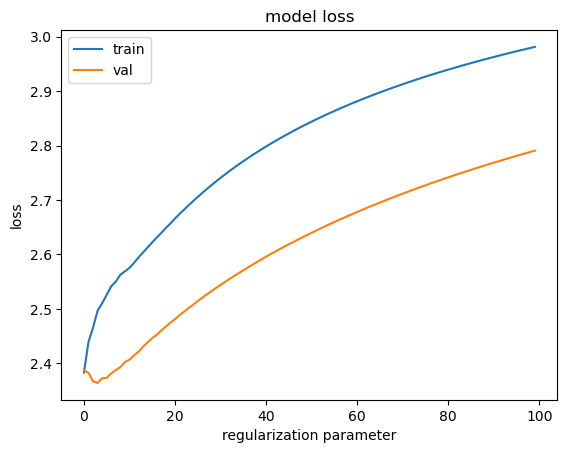

In [64]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('regularization parameter')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we increase the regularization strength, we see that both the losses are increasing and the training loss is increasing over validation loss, it means that the model is underfitting. Lets choose the regularization parameter as 0 and evaluate the test set

In [65]:
model, train_loss = train(x_train, y_train, 100, 10, 0)

In [66]:
train_loss

2.3726656436920166

In [67]:
evaluate_loss(model, x_valid, y_valid)

2.374793767929077

In [68]:
evaluate_loss(model, x_test, y_test)

2.383634328842163

## E04
 > We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [69]:
xs.shape

torch.Size([196113, 2])

In [70]:
xenc_num

196113

In [71]:
x_train, y_train = xs[train_idx], ys[train_idx]
x_valid, y_valid = xs[valid_idx], ys[valid_idx]
x_test, y_test = xs[test_idx], ys[test_idx]

In [72]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    assert X.shape[-1] == 2
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        
        #indexing
        W1 = W[:27]
        W2 = W[27:]
        
        logits = W1[X[:, 0]] + W2[X[:, 1]]
        
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [73]:
model, train_loss = train(x_train, y_train, 100, 10, 0)

In [74]:
train_loss

tensor(2.3768, grad_fn=<AddBackward0>)

In [75]:
def evaluate_loss(model, x, y):
    W1 = model[:27]
    W2 = model[27:]
    
    logits = W1[x[:, 0]] + W2[x[:, 1]]
    
    counts = logits.exp()
    prob = counts/counts.sum(1, keepdims=True)
    return -prob[torch.arange(x.shape[0]), y].log().mean()

In [76]:
evaluate_loss(model, x_valid, y_valid)

tensor(2.3810, grad_fn=<NegBackward0>)

In [77]:
evaluate_loss(model, x_test, y_test)

tensor(2.3880, grad_fn=<NegBackward0>)

## E05
> Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [78]:
x_train, y_train = xenc_flattened[train_idx], ys[train_idx]
x_valid, y_valid = xenc_flattened[valid_idx], ys[valid_idx]
x_test, y_test = xenc_flattened[test_idx], ys[test_idx]

In [79]:
def train(X, y, epochs, lr, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        loss = F.cross_entropy(logits, y)
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [80]:
def evaluate_loss(model, x, y):
    logits = x @ model
    counts = logits.exp()
    pred = counts/counts.sum(1, keepdims=True)
    return - pred[torch.arange(x.shape[0]), y].log().mean().item()

In [81]:
model, loss = train(x_train, y_train, 100, 10, 0)

In [82]:
loss

tensor(2.3824, grad_fn=<NllLossBackward0>)

In [83]:
evaluate_loss(model, x_valid, y_valid)

2.3871989250183105

In [84]:
evaluate_loss(model, x_test, y_test)

2.3962411880493164

Using `F.cross_entropy`, we dont have to compute the counts and probabilities ourselves instead we just have to pass the logits and labels to the function, also we can pass the weight given to each class and label smoothing

### E06
> meta-exercise! Think of a fun/interesting exercise and complete it.

Lets introduce bias, activation function and another layer of weight in the neural network 

In [139]:
relu = torch.nn.ReLU() # activation

In [179]:
def train(X, y, epochs, lr, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W1 = torch.randn((54, 50), requires_grad=True, generator=g)
    W2 = torch.randn((50, 27), requires_grad=True, generator=g)
    b = torch.zeros(50, requires_grad=True)
    
    for i in range(epochs):
        
        #first layer
        output = relu(X @ W1 + b)
        
        # second layer
        logits = output @ W2
        loss = F.cross_entropy(logits, y)
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W1.grad = None
        W2.grad = None
        b.grad = None
        
        loss.backward()
        W1.data += -lr * W1.grad 
        W2.data += -lr * W2.grad 
        b.data += -lr * b.grad
        
    if print_at_last: print(f'Loss {loss}')
    return W1, W2, b, loss

In [181]:
params1, params2, bias,  loss = train(x_train, y_train, 100, 5, print_at_every_epoch = True, print_at_last = True)

Epoch 0 Loss 14.356369018554688
Epoch 1 Loss 6.445797443389893
Epoch 2 Loss 4.845088958740234
Epoch 3 Loss 3.610227346420288
Epoch 4 Loss 3.2677083015441895
Epoch 5 Loss 3.147526264190674
Epoch 6 Loss 3.073038339614868
Epoch 7 Loss 3.011115789413452
Epoch 8 Loss 2.9635703563690186
Epoch 9 Loss 2.9246973991394043
Epoch 10 Loss 2.889881134033203
Epoch 11 Loss 2.8589870929718018
Epoch 12 Loss 2.8271501064300537
Epoch 13 Loss 2.7997994422912598
Epoch 14 Loss 2.777028799057007
Epoch 15 Loss 2.7568700313568115
Epoch 16 Loss 2.738692283630371
Epoch 17 Loss 2.7220845222473145
Epoch 18 Loss 2.7064385414123535
Epoch 19 Loss 2.6917459964752197
Epoch 20 Loss 2.678067922592163
Epoch 21 Loss 2.664644956588745
Epoch 22 Loss 2.65147066116333
Epoch 23 Loss 2.6392555236816406
Epoch 24 Loss 2.627774715423584
Epoch 25 Loss 2.6169304847717285
Epoch 26 Loss 2.606522798538208
Epoch 27 Loss 2.5968828201293945
Epoch 28 Loss 2.5878326892852783
Epoch 29 Loss 2.5790443420410156
Epoch 30 Loss 2.5707550048828125
Ep

In [182]:
def evaluate_loss(X, y, W1, W2, b):
    #first layer
    output = relu(X @ W1 + b)
        
    # second layer
    logits = output @ W2
    loss = F.cross_entropy(logits, y)
    return loss

In [183]:
evaluate_loss(x_valid, y_valid, params1, params2, bias)

tensor(2.3898, grad_fn=<NllLossBackward0>)

In [184]:
evaluate_loss(x_test, y_test, params1, params2, bias)

tensor(2.4028, grad_fn=<NllLossBackward0>)